# Image Captioning


通过Inception_v3 模型，生成图像的transfer_values，并保存为image_features-.pickle文件，用于Image Caption 模型的训练<br>
图像来自flickr30k_images

## Flowchart（inception v3流程图）
![Inception v3](./img/inceptionv3onc--oview.png ) 

### pool_3的结构示意图
![png](./img/pool_3.PNG)

In [1]:
import os
import sys
import tensorflow as tf
from tensorflow import gfile
from tensorflow import logging
import pprint
import pickle
import numpy as np
import tqdm
import jieba
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.10.0'

In [3]:
model_file = "./inception_v3/inception_v3_graph_def.pb"
input_description_file = "./data/zh_results_20130124.token"
input_img_dir = "./data/flickr30k_images/"
output_folder = "./feature_extraction_inception_v3"
batch_size = 100

#下面这两句代码已经没有使用os的api了，而是使用的gfile里面的api，在一个分布式的环境下，os.api是不起作用的，但是gfile是没有问题的。
#因为os上的api需要调用其他机器上的api
if not gfile.Exists(output_folder):
    gfile.MakeDirs(output_folder)

In [4]:
def parse_token_file(token_file):
    """Parses token file.得到的输出是一个字典，key图像名称，value是一个列表，列表里面是对图像描述"""
    img_name_to_tokens = {}
    with gfile.GFile(token_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        img_id, description = line.strip('\r\n').split('\t')
        img_name, _ = img_id.split('#')
        img_name_to_tokens.setdefault(img_name, [])
        img_name_to_tokens[img_name].append(description)
    return img_name_to_tokens

In [5]:
img_name_to_tokens = parse_token_file(input_description_file)#img_name_to_tokens 一个字典，key图像名称，value描述。
all_img_names = img_name_to_tokens.keys()#获取所有的图像

In [6]:
list(all_img_names)[:10]

['4334910609.jpg',
 '4705094483.jpg',
 '421730441.jpg',
 '129863111.jpg',
 '732001349.jpg',
 '485357535.jpg',
 '2103055320.jpg',
 '3621741935.jpg',
 '4738365740.jpg',
 '2616643090.jpg']

In [7]:
def show_image(name,name_to_tokens):
    """
    
    加载和绘制图像
    """

    #图像文件的路径
    path = './data/flickr30k_images/'
    image_path = path+name
    
    # Load the image and plot it.
    img = plt.imread(image_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    
    # Print the captions for this image. 打印图像的文本标注
    captions = name_to_tokens[name]
    for caption in captions:
        print(caption)

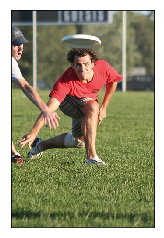

两个男人，一个身穿红色衬衫，奔向飞盘。
在某种体育比赛中，两名男子追逐飞盘。
两名男子正准备赶上飞盘。
一个红衣男子扔飞盘。
两个男人和一个飞盘


In [8]:
show_image(name='229978782.jpg',name_to_tokens=img_name_to_tokens)

In [9]:
def load_pretrained_inception_v3(model_file):
    with gfile.FastGFile(model_file, "rb") as f:
        graph_def = tf.GraphDef()#这是构建一个空的计算图
        graph_def.ParseFromString(f.read())#这里是利用文件句柄把计算图读到空的计算图中去
        _ = tf.import_graph_def(graph_def, name="")#把计算图导入到默认的计算图中去
        #默认的计算图，当打开一个Session之后，起作用的是一个默认的计算图。
load_pretrained_inception_v3(model_file)

In [10]:
'''
将flickr30k中的图像输入到Inception v3网络中，得到transfer_values，
这里使用的inception_v3倒数第二层的tensor，经过average pooling后的，形状是1x1x2048
'''

num_batches = int(len(all_img_names) / batch_size)#扫描一次样本需要运行多少个batch
if len(all_img_names) % batch_size != 0:#这里如果文件数目对batch_size 取模不为零的话，就说明有多余的文件，需要把num_batches 加1
    num_batches += 1

with tf.Session() as sess:
    second_to_last_tensor = sess.graph.get_tensor_by_name("pool_3:0") #这里使用的inception_v3倒数第二层的tensor，经过average pooling
    #后的，形状是1x1x2048
    bar = tqdm.tqdm(range(num_batches))
    for i in bar:
        batch_img_names = list(all_img_names)[i*batch_size: (i+1)*batch_size]
        batch_features = []
        for img_name in batch_img_names:
            img_path = os.path.join(input_img_dir, img_name)
            if not gfile.Exists(img_path):
                raise Exception("%s doesn't exists" % img_path)
            img_data = gfile.FastGFile(img_path, "rb").read()#根据名称读取flickr30k_images中的图像
            feature_vector = sess.run(second_to_last_tensor,
                                      feed_dict = {"DecodeJpeg/contents:0": img_data})
            batch_features.append(feature_vector)
        batch_features = np.vstack(batch_features)
        output_filename = os.path.join(output_folder, "image_features-%d.pickle" % i)
#         bar.set_description("writing to file %s" % output_filename)
        with gfile.GFile(output_filename, 'w') as f:
            pickle.dump((batch_img_names, batch_features), f)

100%|██████████████████████████████████████████████████████████████████████| 318/318 [42:52<00:00,  8.09s/it]
